# Analyzing Doctor Appointment No-Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

We want to analyze a data set to see if we can discover patterns or indicators about whether or not someone is more likely to miss a doctor appointment.

Similar to how airline companies overbook their flights - assuming that some will not show-up - we may want to consider "overbooking" our doctor appointments assuming that some will not show up for their appointment. However, we do not want to be arbitrary in our scheduling.

We can leverage data from over 100,000 records of doctor appointments to uncover insights that can help us determine and predict whether or not they will show up for their appointment, based on a number of factors (health conditions, welfare status, location of doctor's office, and other relevant data points).

This project investigates such data and seeks to explore and reveal helpful insights that can help us make better, more efficient, and more profitable decisions.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from datetime import datetime

<a id='wrangling'></a>
## Data Wrangling

Import the data intro a pandas dataframe and make some general observations.

### General Properties

In [131]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [132]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### Data Cleaning

There are no null values, but there are two changes to make:<br>
1. Convert the No-Show appointment column to a more readable, intuitive name and value. I will change it from the negative to the positive by renaming the column to "ApptResult" with each cooresponding value as "Present" or "Missed."<br>
2. Change the Sholarship column to make the data make more sense<br>
3. To utilize the dates provided, I will parse out the month and the day for both the scheduled date and the appointment date.<br>
4. Remove same-day / walk-in appointments.<br>

Upon making these changes, I will export to a new, cleaned CSV file for future use.

#### Clean the No-show column

I want to first change the column name from No-show to ApptResult. This column name will be more intuitive to interpret.

In [133]:
df.rename(columns = {'No-show' : 'ApptResult'} , inplace=True)

Once we rename the column from No-show (which is in the negative), we need to rename the ApptResult column values from a "Yes" or "No" value to "Missed" or "Present", respectively.

In [134]:
df['ApptResult'].replace("No", 1, inplace=True)
df['ApptResult'].replace("Yes", 0, inplace=True)

#### Change Scholarship column to say WelfareScholarship

In [135]:
df.rename(columns = {'Scholarship' : 'WelfareScholarship'} , inplace=True)

#### Clean the date columns and add a new column that calculates the difference

Convert the AppointmentDate and ScheduledDate to datetime format

In [137]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format="%Y-%m-%d").dt.date
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format="%Y-%m-%d").dt.date

Add a column to the dataframe "DateDifference" to the dataframe

In [138]:
df['DateDifference'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

Retain rows where DateDifference is greater than 0. We can assume that these are walk-in appointments, and appointments scheduled after the appointment date must be a data-entry error.

In [139]:
df = df[df['DateDifference'] > 0]

#### Export the cleaned data to a new CSV

In [140]:
df.to_csv('cleaned-noshowappointments.csv', index=False)

In [141]:
df = pd.read_csv('cleaned-noshowappointments.csv')

In [142]:
df.query('ApptResult == 1').to_csv('appts-present.csv')
df.query('ApptResult == 0').to_csv('appts-missed.csv')

<a id='eda'></a>
## Exploratory Data Analysis

In [70]:
df = pd.read_csv('cleaned-noshowappointments.csv')
df_m = pd.read_csv('appts-missed.csv')
df_p = pd.read_csv('appts-present.csv')

In [71]:
df['ApptResult'].describe()
mean = df['ApptResult'].describe()[1]

##### Observations:
<li>71.4% of patients will show up for their appointment
<li>28.6% of patients will not show up for their appointment

#### 1. Does the amount of days between the schedule date and appointment date show a correlation to a missed appointment?

By looking at value_counts and analyzing the appointments histogram, we see that the data quickly tails off after 90 days. So we will examine two time periods: 0-30 days, the period with the most activity, and 0-90 days, covering a healthy spread.

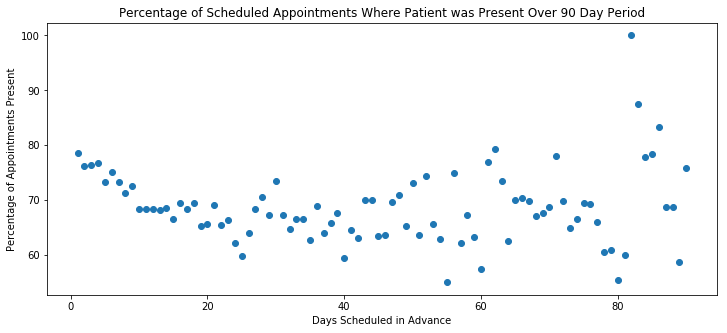

In [72]:
start = 0
end = 90
y = df.groupby('DateDifference')['ApptResult'].mean()[start:end]*100
x = range(start + 1, end + 1)
plt.figure(figsize=(12,5))
plt.scatter(x,y);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 90 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");

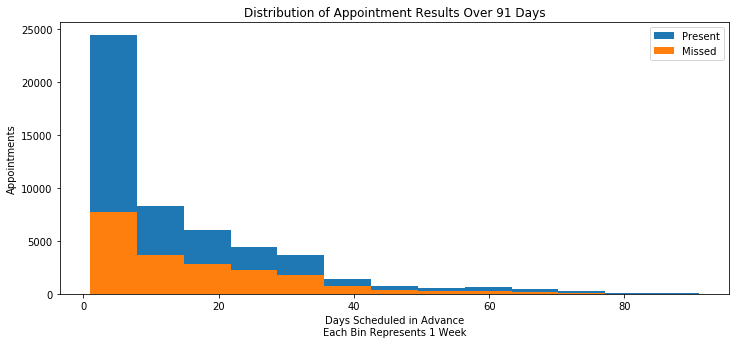

In [73]:
plt.figure(figsize=(12,5))
plt.hist(df_p['DateDifference'], bins=13, range=(start + 1,end + 1));
plt.hist(df_m['DateDifference'], bins=13, range=(start + 1,end + 1));
plt.legend(['Present','Missed']);
plt.title('Distribution of Appointment Results Over 91 Days');
plt.xlabel('Days Scheduled in Advance\nEach Bin Represents 1 Week')
plt.ylabel('Appointments');

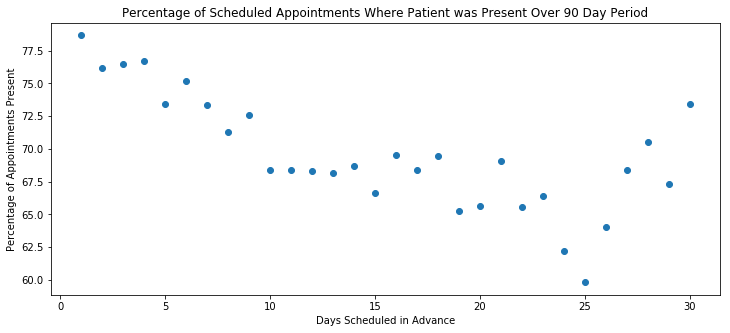

In [74]:
start = 0
end = 30
y = df.groupby('DateDifference')['ApptResult'].mean()[start:end]*100
x = range(start + 1, end + 1)
plt.figure(figsize=(12,5))
plt.scatter(x,y);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 90 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");

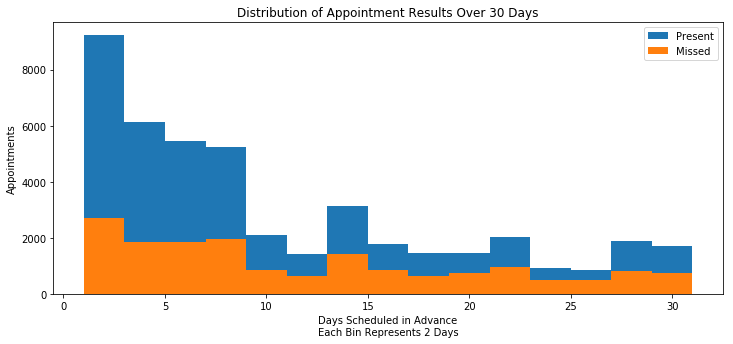

In [75]:
plt.figure(figsize=(12,5))
plt.hist(df_p['DateDifference'], bins=15, range=(start + 1,end + 1));
plt.hist(df_m['DateDifference'], bins=15, range=(start + 1,end + 1));
plt.legend(['Present','Missed']);
plt.title('Distribution of Appointment Results Over 30 Days');
plt.xlabel('Days Scheduled in Advance\nEach Bin Represents 2 Days')
plt.ylabel('Appointments');

##### Observations:
We can say that there exists a relationship between the number of days in advance an appointment is scheduled and the liklihood of them missing the appointment. Average number of appointments present starts in the high 70s in the first week, and quickly goes down to the 60s and lower.

Additional Investigation: For days 0-60, did an SMS reminder impact a patient's liklihood to show up for their appointment?

In [76]:
df1 = df.query('SMS_received == 1')
df1 = df1.groupby('DateDifference')['ApptResult'].mean()

df2 = df.query('SMS_received == 0')
df2 = df2.groupby('DateDifference')['ApptResult'].mean()

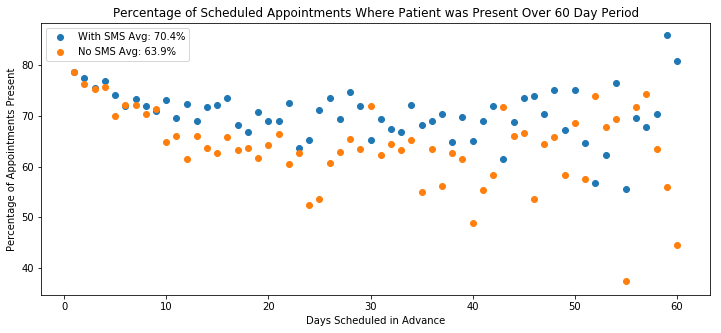

In [77]:
start = 0
end = 60

avg_result_SMS = df1[start:end].mean()
avg_result_NoSMS = df2[start:end].mean()

y1 = df1[start:end]*100
y2 = df2[start:end]*100
x = range(start + 1, end + 1)

plt.figure(figsize=(12,5))
plt.scatter(x,y1);
plt.scatter(x,y2);
plt.title("Percentage of Scheduled Appointments Where Patient was Present Over 60 Day Period");
plt.xlabel("Days Scheduled in Advance");
plt.ylabel("Percentage of Appointments Present");
plt.legend(['With SMS Avg: {}%'.format(round(avg_result_SMS*100,1)),'No SMS Avg: {}%'.format(round(avg_result_NoSMS*100,1))]);

##### Observations:
There seems to exist a relationship between of an SMS and attendance, as patients are 6.5% more likely to show up for their appointment when receiving an SMS reminder.

#### 2. What role might the location of the facility and a person's welfare status have on the likelihood of a missed appointment?

First, let's investigate the role of the facility's location on the liklihood of a patient showing up for their appointment or not.

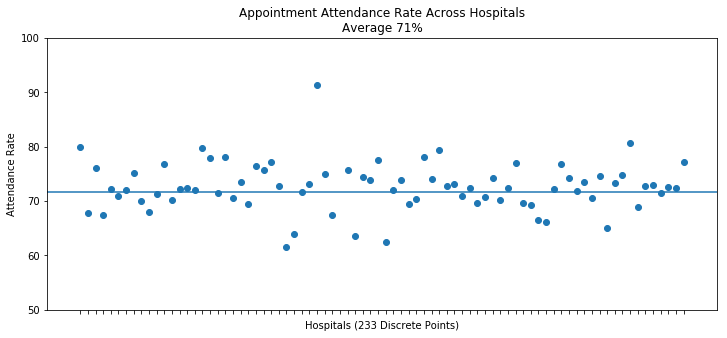

In [78]:
plt.figure(figsize=(12,5))
df1 = df.groupby('Neighbourhood')['ApptResult'].mean()*100
avg_neighborhood = df1.mean()

y = df1
x = range(1,len(y)+1)
plt.xticks(x, "");
plt.scatter(x,y);
plt.axhline(y=avg_neighborhood)
plt.ylim((50,100))
plt.title('Appointment Attendance Rate Across Hospitals\nAverage 71%');
plt.xlabel('Hospitals (233 Discrete Points)');
plt.ylabel('Attendance Rate');

##### Observations:
It looks like there could exist some correlation between the facility location and the liklihood of a patient showing up for their appointment. Let's combine this analysis with a patient's Welfare status.

In [79]:
welfare_mean = df['WelfareScholarship'].describe()[1]
welfare_mean_present = df_p['WelfareScholarship'].describe()[1]
welfare_mean_missed = df_m['WelfareScholarship'].describe()[1]

mean_result_welfare = df['ApptResult'].mean()
mean_result_if_welfare = df.groupby('WelfareScholarship')['ApptResult'].mean()[0]
mean_result_not_welfare = df.groupby('WelfareScholarship')['ApptResult'].mean()[1]

##### Observations:
<li>9.2% of patients are on welfare status.</li>
<li>The Mean Welfare status for present appointments is 8.4%, or .8% lower than the overall average</li>
<li>The Mean Welfare status for missed appointments is 11.4%, or 2.2% higher that the overall average</li>
<li>If the patient is on Welfare, there is a 65.0% liklihood they will show up for their appointment, or 6.5% more likely to miss their appointment</li>
<li>If the patient is not on Welfare, there is a 72.1% liklihood they will show up for their appointment, or .6% more likely to show up for their appointment</li>

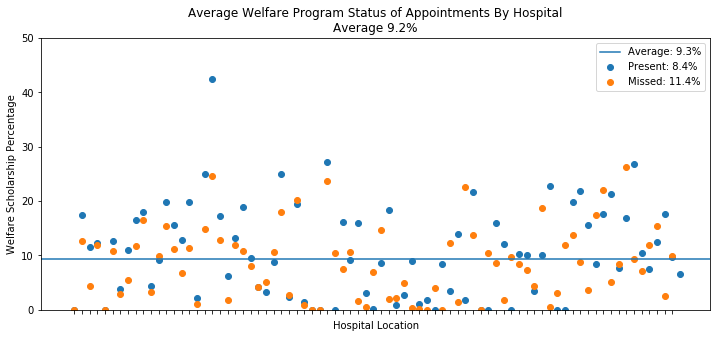

In [80]:
plt.figure(figsize=(12,5))

y = df_m.groupby('Neighbourhood')['WelfareScholarship'].mean()*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = df_p.groupby('Neighbourhood')['WelfareScholarship'].mean()*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.axhline(y=welfare_mean*100)
plt.ylim(0,50)
plt.xticks(x, '');
plt.title('Average Welfare Program Status of Appointments By Hospital\nAverage 9.2%');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Hospital Location')
plt.legend(['Average: {}%'.format(round(welfare_mean*100,1)),'Present: {}%'.format(round(welfare_mean_present*100,1)),'Missed: {}%'.format(round(welfare_mean_missed*100,1))]);

In [81]:
df_neighborhoods = df.groupby('Neighbourhood').mean()

When Neighborhoods are above the mean Attendance rate and below the mean Welfare Scholarship rate, what is the mean Welfare Scholarship rate? How does this compare to the mean Welfare Scholarship rate when only the Attendance Rate is above the mean and when only when the Welfare Sholarship rate is less than the mean?

In [82]:
means_Aw = df_neighborhoods.query('ApptResult > {} and WelfareScholarship < {}'.format(mean,welfare_mean))['WelfareScholarship']
means_AW = df_neighborhoods.query('ApptResult > {} and WelfareScholarship > {}'.format(mean,welfare_mean))['WelfareScholarship']
means_aW = df_neighborhoods.query('ApptResult < {} and WelfareScholarship > {}'.format(mean,welfare_mean))['WelfareScholarship']
means_aw = df_neighborhoods.query('ApptResult < {} and WelfareScholarship < {}'.format(mean,welfare_mean))['WelfareScholarship']
means_A = df_neighborhoods.query('ApptResult > {}'.format(mean)).mean()['WelfareScholarship']
means_a = df_neighborhoods.query('ApptResult < {}'.format(mean)).mean()['WelfareScholarship']
means_w = df_neighborhoods.query('WelfareScholarship < {}'.format(welfare_mean)).mean()['WelfareScholarship']
means_W = df_neighborhoods.query('WelfareScholarship > {}'.format(welfare_mean)).mean()['WelfareScholarship']

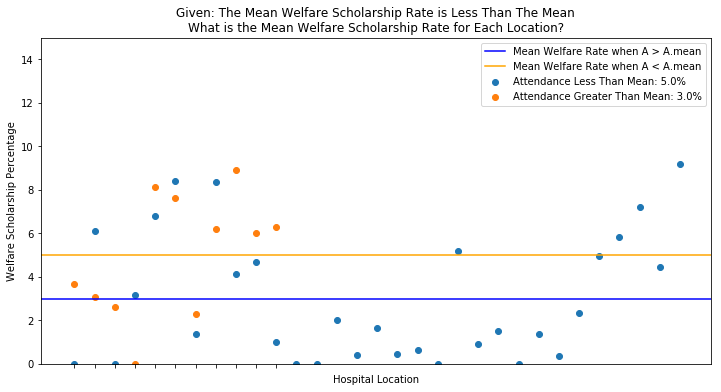

In [83]:
plt.figure(figsize=(12,6))

plt.axhline(y=means_Aw.mean()*100, color='blue')
plt.axhline(y=means_aw.mean()*100, color='orange')

y = means_Aw*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = means_aw*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.ylim(0,15)
plt.xticks(x, '');
plt.title('Given: The Mean Welfare Scholarship Rate is Less Than The Mean\nWhat is the Mean Welfare Scholarship Rate for Each Location?');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Hospital Location')
plt.legend(['Mean Welfare Rate when A > A.mean','Mean Welfare Rate when A < A.mean','Attendance Less Than Mean: {}%'.format(round(means_aw.mean()*100,1)),'Attendance Greater Than Mean: {}%'.format(round(means_Aw.mean()*100,1))]);

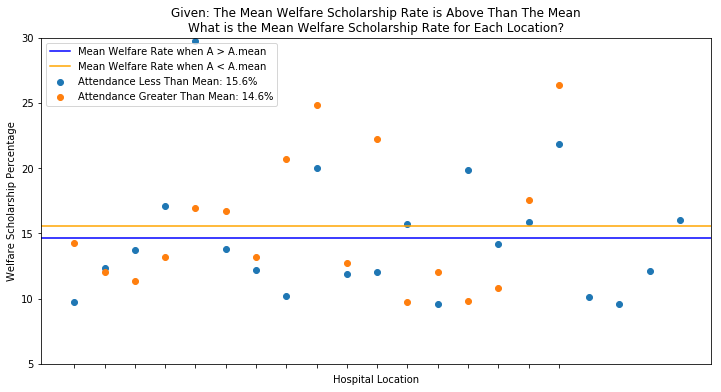

In [68]:
plt.figure(figsize=(12,6))

plt.axhline(y=means_AW.mean()*100, color='blue')
plt.axhline(y=means_aW.mean()*100, color='orange')

y = means_AW*100
x = range(1,len(y)+1)
plt.scatter(x,y);

y = means_aW*100
x = range(1,len(y)+1)
plt.scatter(x,y);

plt.ylim(5,30)
plt.xticks(x, '');
plt.title('Given: The Mean Welfare Scholarship Rate is Above Than The Mean\nWhat is the Mean Welfare Scholarship Rate for Each Location?');
plt.ylabel('Welfare Scholarship Percentage');
plt.xlabel('Hospital Location')
plt.legend(['Mean Welfare Rate when A > A.mean','Mean Welfare Rate when A < A.mean','Attendance Less Than Mean: {}%'.format(round(means_aW.mean()*100,1)),'Attendance Greater Than Mean: {}%'.format(round(means_AW.mean()*100,1))]);

##### Observations:
<li>It looks like there exists a consistent, al beit marginal, correlation between Welfare Scholarship rate and liklihood to show up for an appointment.</li>
<li>For hospitals whose patients' welfare rate is below the overall average, the mean attendance rate is 2.0% higher among patients whose welfare rate was below the mean.</li>
<li>For hospitals whose patients' welfare rate is above the overall average, the mean attendance rate is 1.2% higher among patients whose welfare rate was below the mean.</li>

#### 3. Does a person's health conditions affect the likelihood of mission an appointment?

In [98]:
p_means = df_p.mean()
m_means = df_m.mean()

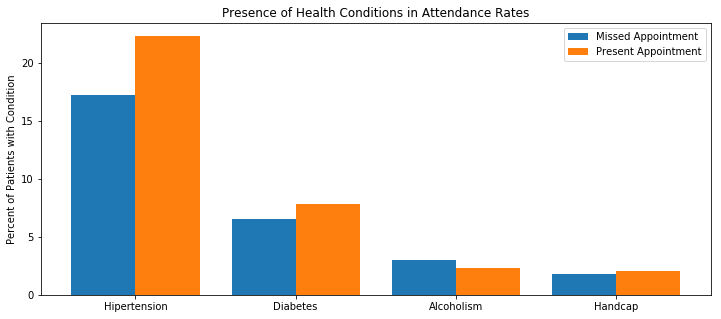

In [380]:
import numpy as np
plt.figure(figsize=(12,5))
plt.title('Presence of Health Conditions in Attendance Rates')

w = .4
labels = m_means.index[5:-3].tolist()
location = np.arange(1,len(xvalues)+1) + w/2

y_m = m_means[5:-3]*100;
y_p = p_means[5:-3]*100;
plt.bar(location-w/2,y_m, width=w, label='Missed Appointment');
plt.bar(location+w/2,y_p, width=w, label='Present Appointment');

plt.xticks(location, labels);
plt.ylabel('Percent of Patients with Condition');
plt.legend();

In [205]:
p_means[5:-3] - m_means[5:-3]

Hipertension    0.051194
Diabetes        0.013052
Alcoholism     -0.006911
Handcap         0.002451
dtype: float64

##### Observation:
Hipertension looks to be a more common health condition than there other conditions. All health conditions except Alocholism positively impact the attendance rate, while an alcoholic patient is more likely to miss an appointment.

In [383]:
hipertension_rate = df.query('Hipertension == 1')['ApptResult'].mean()*100
diabetes_rate = df.query('Diabetes == 1')['ApptResult'].mean()*100
alcoholism_rate = df.query('Alcoholism == 1')['ApptResult'].mean()*100
hipertension_rate = df.query('Handcap == 1')['ApptResult'].mean()*100

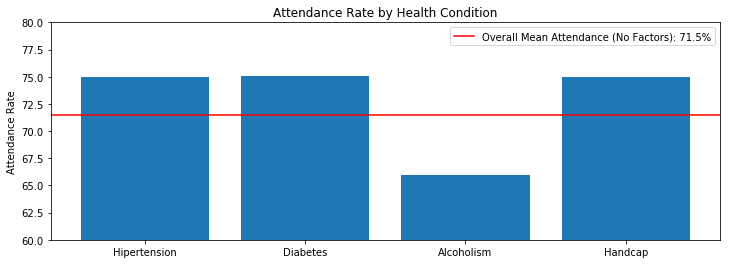

In [384]:
labels = m_means.index[5:-3].tolist()
x = range(1, len(labels)+1)
y = [hipertension_rate, diabetes_rate, alcoholism_rate, hipertension_rate]
mean_y = sum(y) / len(y)

plt.figure(figsize=(12,4))
plt.axhline(mean*100, label='Overall Mean Attendance (No Factors): {}%'.format(round(mean*100,1)), color='r');
plt.bar(x,y);
plt.xticks(x,labels);
plt.ylim(60,80);
plt.title('Attendance Rate by Health Condition')
plt.ylabel('Attendance Rate');
plt.legend();

Let's isolate and anlayze the three health conditions that positively impact the attendance rate - Hipertension, Diabetes, Handcap. And then let's consider Alocholism and separate this field to think of it as an inverse factor.

In [389]:
no_condition_rate = df.query('Handcap == 0 and Hipertension == 0 and Diabetes == 0')['ApptResult'].mean()*100
any_condition_rate = df.query('Handcap == 1 or Hipertension == 1 or Diabetes == 1')['ApptResult'].mean()*100
all_condition_rate = df.query('Handcap == 1 and Hipertension == 1 and Diabetes == 1')['ApptResult'].mean()*100

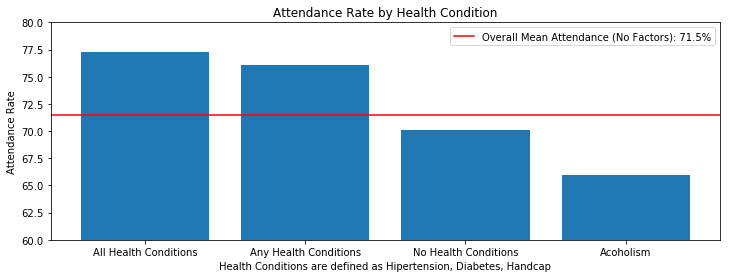

In [390]:
labels = ['All Health Conditions','Any Health Conditions','No Health Conditions','Acoholism']
x = range(1, len(labels)+1)
y = [all_condition_rate, any_condition_rate, no_condition_rate, alcoholism_rate]

plt.figure(figsize=(12,4))
plt.bar(x,y);
plt.axhline(mean*100, label='Overall Mean Attendance (No Factors): {}%'.format(round(mean*100,1)), color='r');
plt.xticks(x,labels);
plt.ylim(60,80);
plt.title('Attendance Rate by Health Condition')
plt.ylabel('Attendance Rate');
plt.xlabel('Health Conditions are defined as Hipertension, Diabetes, Handcap')
plt.legend();

##### Observation:
A patient is more likely to show up to their appointment if they have a health condition (hipertension, diabetes, handcap):
<li>77.3% attendance rate if patient has all hipertension, diabetes, and handcap, or 5.8% higher than the average</li>
<li>76.1% attendance rate if patient has at least one of hipertension, diabetes, or handcap, or 4.6% higher than the average</li>
<li>70.1% attendance rate if patient has no condition, or 1.4% lower than the average</li>
<li>65.9% attendance rate if patient has alcoholism, or 5.6% lower than the average</li>

### <a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!